<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [2]:
## install finrl library
!pip install wrds
# !pip install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     --- ------------------------------------ 0.1/1.6 MB 4.3 MB/s eta 0:00:01
     ---------------- ----------------------- 0.6/1.6 MB 8.1 MB/s eta 0:00:01
     ------------------------------ --------- 1.2/1.6 MB 9.6 MB/s eta 0:00:01
     ---------------------------------------  1.6/1.6 MB 10.0 MB/s eta 0:00:01
     ---------------------------------------- 1.6/1.6 MB 8.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     -------------------- ------------------- 0.6/1.2 MB 12.7 MB/s eta 0:00:01
     ---------------------------------------  1.1/1.2 MB 12.2 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.5.post1
    Uninstalling SQLAlchemy-2.0.5.post1:
      Successfully uninstalled SQLAlchemy-2.0.5.post1



<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools
import random
import json

C:\Users\abdel\.conda\envs\finrl\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings("ignore")

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
print(f"DATA_SAVE_DIR: {DATA_SAVE_DIR}")
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



DATA_SAVE_DIR: abdelhakim_extra/rllib/datasets


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [4]:
# from config.py, TRAIN_START_DATE is a string
print(f"TRAIN_START_DATE: {TRAIN_START_DATE}")
# from config.py, TRAIN_END_DATE is a string
print(f"TRAIN_END_DATE: {TRAIN_END_DATE}")

TRAIN_START_DATE: 2014-01-06
TRAIN_END_DATE: 2020-07-31


In [5]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'

In [6]:
if os.path.exists("abdelhakim_extra/yahoo_data.csv"):
    df = pd.read_csv("abdelhakim_extra/yahoo_data.csv", index_col=0)
else:
    df = YahooDownloader(
        start_date = TRAIN_START_DATE,
        end_date = TRADE_END_DATE,
        ticker_list = config_tickers.DOW_30_TICKER
    ).fetch_data()
    if not os.path.exists("abdelhakim_extra"):
        os.makedirs("abdelhakim_extra")
    df.to_csv("abdelhakim_extra/yahoo_data.csv")

In [7]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.758535,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.832634,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.365306,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.579323,7117200,CAT,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [9]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature = False
)
processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [11]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758535,746015200.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,2.758535,2.758535,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.832634,6547900.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,43.832634,43.832634,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.365306,10955700.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,15.365306,15.365306,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,33.941097,33.941097,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.579323,7117200.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,31.579323,31.579323,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,11.948334,40980600.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,11.948334,11.948334,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,43.677185,13695900.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,43.677185,43.677185,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597498,9796600.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,20.597498,20.597498,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,69.251740,14088500.0,4.0,0.0,2.981393,2.6521,100.0,66.666667,100.0,69.251740,69.251740,39.189999,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [12]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

83897
9744


In [13]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [14]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

# e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment Creator for Training in RLLIB

* In RLLIB, an env creator is a function that take as input an EnvContext object (Dict containing the config), and outputs the envirnoment object instanciated with the parameters from the EnvContext.
* We are gonna wrap the envirnoment class in the EnvCompatibility wrapper fro *gymnasium* to account for the changes in the gym API (considered by ray 2.3.0)
* Finally, we are gonna register the environment to ray so that it would be accessible in the DRL trainers.



In [15]:
import ray
from ray.tune.registry import register_env

from gymnasium.wrappers import EnvCompatibility

In [16]:
def env_creator(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', train)
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling
    ))

# registering the environment to ray
register_env("finrl", env_creator)

<a id='5'></a>
# Part 6: Train RLLIB DRL Agents
* We will initialize a ray instance specifying the resources we put at its disposal
* We will then initialize the config object from the respective default configuration of the algorithm we are going to use. We can then add environment specific parameters, and parallelization specific parameters.
* Finally, we instanciate the trainer and launch the training loop

In [17]:
from ray.rllib.agents import ppo

* Set this to True if you want to run DDPPO instead of PPO

In [18]:
use_ddppo = True

### Init ray

In [19]:
if ray.is_initialized():
    ray.shutdown()
print(f"ray is being initialized")
ray.init(_temp_dir="C:/Users/abdel/Documents/Work/Freelance/FinRL/RLLIB/results", num_cpus=2, num_gpus=0)

ray is being initialized


2023-03-25 13:35:34,066	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.16
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


### Define Config

In [20]:
def pretty(d, indent=1):
    for key, value in d.items():
        print('\t' * indent + str(key) + ':')
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [21]:
if use_ddppo:
    config = ppo.DDPPOConfig()
else:
    config = ppo.PPOConfig()

# Here set envirnonment parameters if different from default
config = config.environment(
    env_config={'hmax':100, 'initial_amount':1000000}
)

# Training
config = config.training()

# Resources
config = config.resources(
    num_gpus=0,
    num_cpus_per_worker=1,
    num_gpus_per_worker=0,
    num_trainer_workers=2,
    num_gpus_per_trainer_worker = 0,
    num_cpus_per_trainer_worker = 1,
)
# Framework
config = config.framework(
    framework="torch",
)
# Rollouts
config = config.rollouts(
    num_rollout_workers=2,
    num_envs_per_worker=1,
)

print(config)
# pretty(config.to_dict())

### Instanciate trainer

In [22]:
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl', config=config)
else:
    trainer = ppo.PPOTrainer(env='finrl', config=config)

2023-03-25 13:36:42,430	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl').build()` instead. This will raise an error in the future!
2023-03-25 13:36:42,722	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=25472) C:\Users\abdel\.conda\envs\finrl\lib\site-packages\gymnasium\wrappers\compatibility.py:67: UserWarning: WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v0.28. Instead use `gym.make('GymV22Environment-v0', env_name=...)` or `from shimmy import GymV22CompatibilityV0`
(RolloutWorker pid=25472)   logger.warn(
(RolloutWorker pid=25472) C:\Users\abdel\.conda\envs\finrl\lib\site-packages\gymnasium\spaces\box.py:228: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=25472)   gym.logger.warn("Cast

### Training loop

In [23]:
from tqdm.notebook import tqdm

In [24]:
# (4) Train away -------------------------------------------------------------
total_episodes=50
ep = 0
results = []
bar = tqdm(total=total_episodes, desc="Episodes")
while ep <= total_episodes:
    results.append(trainer.train())
    ep += 1
    bar.update(n=1)
bar.close()

# save the trained agent
agent_name = 'ppo'
if use_ddpo:
    agent_name = 'ddppo'
cwd_checkpoint = "C:/Users/abdel/Documents/Work/Freelance/FinRL/RLLIB/results/checkpoints/" + str(agent_name) + '_' + str(ep)
trainer.save(cwd_checkpoint)

Episodes:   0%|          | 0/50 [00:00<?, ?it/s]

(RolloutWorker pid=25472) C:\Users\abdel\.conda\envs\finrl\lib\site-packages\torch\distributed\distributed_c10d.py:1577: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=25472)   warnings.warn(
(RolloutWorker pid=12416) 2023-03-25 13:38:04,576	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=12416) C:\Users\abdel\.conda\envs\finrl\lib\site-packages\torch\distributed\distributed_c10d.py:1577: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=12416)   warnings.warn(
(RolloutWorker pid=25472) C:\Users\abdel\.conda\envs\finrl\lib\site-packages\torch\

(RolloutWorker pid=25472) day: 2892, episode: 10
(RolloutWorker pid=25472) begin_total_asset: 1000000.00
(RolloutWorker pid=25472) end_total_asset: 5144741.91
(RolloutWorker pid=25472) total_reward: 4144741.91
(RolloutWorker pid=25472) total_cost: 207619.77
(RolloutWorker pid=25472) total_trades: 70673
(RolloutWorker pid=25472) Sharpe: 0.803
(RolloutWorker pid=25472) =================================
(RolloutWorker pid=12416) day: 2892, episode: 10
(RolloutWorker pid=12416) begin_total_asset: 1000000.00
(RolloutWorker pid=12416) end_total_asset: 4412927.04
(RolloutWorker pid=12416) total_reward: 3412927.04
(RolloutWorker pid=12416) total_cost: 281332.22
(RolloutWorker pid=12416) total_trades: 75109
(RolloutWorker pid=12416) Sharpe: 0.735
(RolloutWorker pid=12416) =================================


(RolloutWorker pid=25472) C:\Users\abdel\.conda\envs\finrl\lib\site-packages\torch\distributed\distributed_c10d.py:1577: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=25472)   warnings.warn(
(RolloutWorker pid=12416) C:\Users\abdel\.conda\envs\finrl\lib\site-packages\torch\distributed\distributed_c10d.py:1577: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=12416)   warnings.warn(


NameError: name 'use_ddpo' is not defined

In [25]:
# save the trained agent
agent_name = 'ppo'
if use_ddppo:
    agent_name = 'ddppo'
cwd_checkpoint = "C:/Users/abdel/Documents/Work/Freelance/FinRL/RLLIB/results/checkpoints/" + str(agent_name) + '_' + str(ep)
trainer.save(cwd_checkpoint)

'C:/Users/abdel/Documents/Work/Freelance/FinRL/RLLIB/results/checkpoints/ddppo_51\\checkpoint_000051'

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [26]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [27]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [28]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [29]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.567957
std        43.790823
min         0.000000
25%        14.962833
50%        24.124344
75%        39.162366
max       652.505533
Name: turbulence, dtype: float64

In [30]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45058056873484

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [31]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

## Environment Creator for Trading in RLLIB

* Similarly to the training env, we create an env creator for the trading environment

In [36]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))

# registering the environment to ray
register_env("finrl_trading", env_creator_trading)

In [33]:
if ray.is_initialized():
    ray.shutdown()
print(f"ray is being initialized")
ray.init(_temp_dir="C:/Users/abdel/Documents/Work/Freelance/FinRL/RLLIB/results/trading", num_cpus=2, num_gpus=0)

ray is being initialized


2023-03-25 13:46:17,860	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.16
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [37]:
if use_ddppo:
    config = ppo.DDPPOConfig()
else:
    config = ppo.PPOConfig()

# Here set envirnonment parameters if different from default
config = config.environment(
    env_config={'hmax':100, 'initial_amount':1000000}
)

# Training
config = config.training()

# Resources
config = config.resources(
    num_gpus=0,
    num_cpus_per_worker=1,
    num_gpus_per_worker=0,
    num_trainer_workers=2,
    num_gpus_per_trainer_worker = 0,
    num_cpus_per_trainer_worker = 1,
)
# Framework
config = config.framework(
    framework="torch",
)
# Rollouts
config = config.rollouts(
    num_rollout_workers=2,
    num_envs_per_worker=1,
)

# Additional because we are evaluating now
config = config.exploration(
    explore=False
)

print(config)
# pretty(config.to_dict())

In [38]:
# define trainer
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl_trading', config=config)
else:
    trainer = ppo.PPOTrainer(env='finrl_trading', config=config)

2023-03-25 13:47:04,179	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
(RolloutWorker pid=8360) C:\Users\abdel\.conda\envs\finrl\lib\site-packages\gymnasium\wrappers\compatibility.py:67: UserWarning: WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v0.28. Instead use `gym.make('GymV22Environment-v0', env_name=...)` or `from shimmy import GymV22CompatibilityV0`
(RolloutWorker pid=8360)   logger.warn(
(RolloutWorker pid=8360) 2023-03-25 13:47:11,261	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=8360) 2023-03-25 13:47:11,262	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments

In [40]:
# load saved agent
cwd_checkpoint = "C:/Users/abdel/Documents/Work/Freelance/FinRL/RLLIB/results/checkpoints/ppo_51/checkpoint_000051"
if use_ddppo:
    cwd_checkpoint = "C:/Users/abdel/Documents/Work/Freelance/FinRL/RLLIB/results/checkpoints/ddppo_51/checkpoint_000051"
print("Restoring from checkpoint path", cwd_checkpoint+"/checkpoint_000051")
trainer.restore(cwd_checkpoint)

2023-03-25 13:47:56,541	INFO trainable.py:791 -- Restored on 127.0.0.1 from checkpoint: C:\Users\abdel\Documents\Work\Freelance\FinRL\RLLIB\results\checkpoints\ddppo_51\checkpoint_000051
2023-03-25 13:47:56,542	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 51, '_timesteps_total': None, '_time_total': 399.94967246055603, '_episodes_total': 16}


Restoring from checkpoint path C:/Users/abdel/Documents/Work/Freelance/FinRL/RLLIB/results/checkpoints/ddppo_51/checkpoint_000051/checkpoint_000051


In [41]:
def DRL_prediction(model, environment):
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state)
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            print("hit end!")
            break
    print("Test Finished!")
    return account_memory, actions_memory

In [42]:
df_account_value, df_actions = DRL_prediction(
    model=trainer, 
    environment = e_trade_gym)

hit end!
Test Finished!


In [43]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.239036e+06
332,2021-10-25,1.241783e+06
333,2021-10-26,1.244695e+06
334,2021-10-27,1.233986e+06
335,2021-10-28,1.241795e+06


In [44]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,100,34,38,43,100,0,0,0,100,...,0,0,0,0,16,100,0,98,40,82
2020-07-02,100,100,-34,-38,-43,-37,0,100,59,100,...,94,16,0,100,-16,64,0,100,-40,-82
2020-07-06,-100,100,75,0,89,-57,0,-77,-17,84,...,100,-8,0,100,24,-49,0,79,0,15
2020-07-07,0,14,-75,100,77,60,0,-15,-23,100,...,100,100,0,43,27,66,100,100,56,100
2020-07-08,0,49,54,59,75,-31,0,-8,100,46,...,-66,40,0,-15,100,100,-77,100,81,3


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [45]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.176353
Cumulative returns     0.241795
Annual volatility      0.128956
Sharpe ratio           1.328094
Calmar ratio           2.007415
Stability              0.895214
Max drawdown          -0.087851
Omega ratio            1.254141
Sortino ratio          1.905862
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.166960
Daily value at risk   -0.015567
dtype: float64


In [46]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [47]:
df_account_value.loc[0,'date']

'2020-07-01'

In [48]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,17.635%
Cumulative returns,24.18%
Annual volatility,12.896%
Sharpe ratio,1.33
Calmar ratio,2.01
Stability,0.90
Max drawdown,-8.785%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.79,2020-09-02,2020-10-30,2021-01-07,92
1,4.01,2021-08-27,2021-09-21,2021-10-15,36
2,3.84,2021-01-20,2021-01-29,2021-03-10,36
3,3.75,2020-07-15,2020-07-31,2020-08-12,21
4,3.69,2021-05-07,2021-07-19,2021-08-06,66


Stress Events,mean,min,max
New Normal,0.07%,-3.62%,2.37%


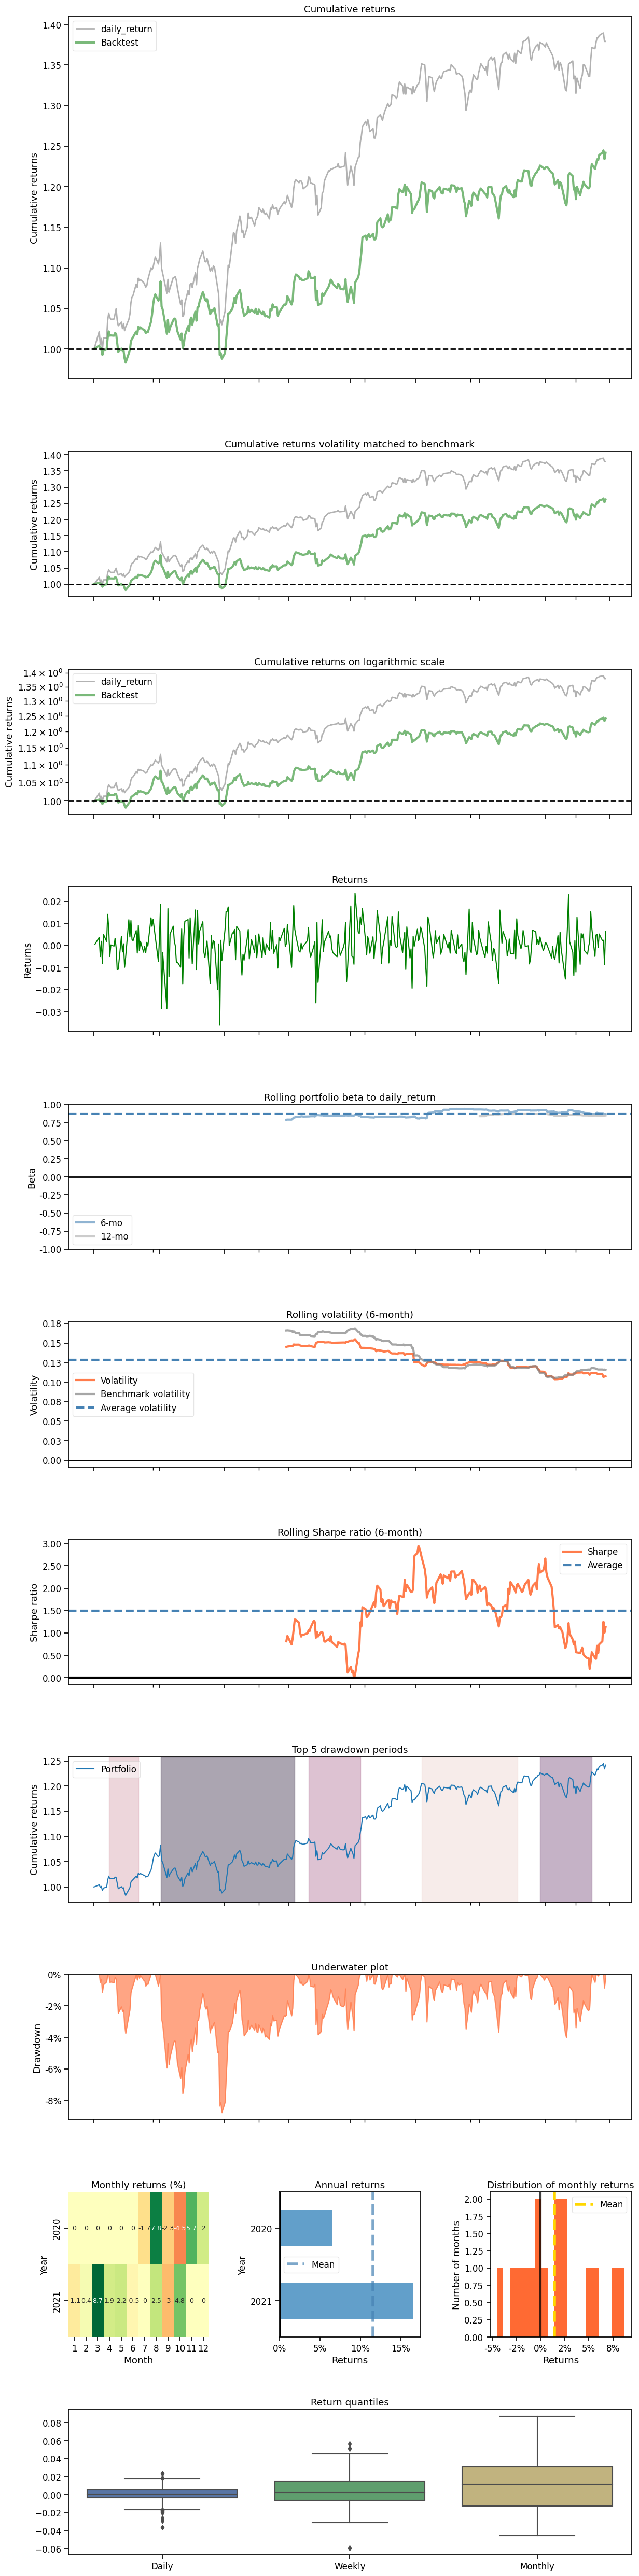

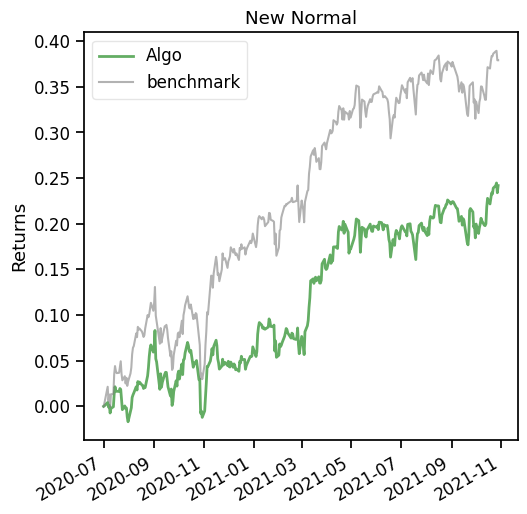

In [49]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])